In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install datasets

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 29.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import string
import emoji
##from pymorphy3 import MorphAnalyzer
#from stop_words import get_stop_words
from transformers import AutoTokenizer, AutoModel
from torch import cuda
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score,f1_score,accuracy_score,confusion_matrix
import optuna
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
#import optuna
np.random.seed(0)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/train - train (3).csv')

In [ ]:
data_train = data_train.drop(columns=['Unnamed: 0'])

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/test_data.csv')

In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [ ]:
X = data_train['message.text']
y = data_train['Оценка']
X_test = data_test['message.text']
y_test = data_test['Оценка']

#Предобработка

In [ ]:
def convert_emojis_to_words(text):

    # Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove the : from the words and replace _ with space
    text = text.replace("_", " ")

    return text

In [ ]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')
#exclude = set(string.punctuation) # удаление пунктуации
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)
    pre = re.sub(r'http\S+', '', pre)
    pre = convert_emojis_to_words(pre)


    return space_pattern.sub(' ', pre)

In [ ]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower()])
    )

    return clear_text(sentence)

In [ ]:
X = X.apply(preprocess_text)

In [ ]:
X_test = X_test.apply(preprocess_text)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 0)

In [ ]:
X_train

,message.text
1371,знакома с большим количеством офисных программ...
1362,"медицинское образование, опыт работы в космето..."
234,привет. меня зовут роман владимирович. у меня ...
2991,ответственный и внимательный к деталям космето...
1931,"ответственная, трудолюбивая, открыта к новым з..."
...,...
835,обязанности: процедуры технического обслужива...
3264,"ответственная, коммуникабельная. обязанности: ..."
1653,я косметолог-эстетист с опытом работы с 2019 г...
2607,"коммуникабельная, вежливая, дисциплинированная..."


# **TF-IDF + LogisticRegression**

In [ ]:
numeric_features = ["Стаж работы","Возраст"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["Тип занятости", "Сфера деятельности", "Образование", "Пол"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
text_transformer = Pipeline(
    steps = [
        ("vectorizer", TfidfVectorizer())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("text", text_transformer,'user_text_info')
    ]
)

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=2000))]
)


clf.fit(X_train, y_train)
print("Accuracy score: %.3f" % clf.score(X_test, y_test))

Accuracy score: 0.729


In [ ]:
pred = clf.predict(X_test)

In [ ]:
balanced_accuracy = balanced_accuracy_score(y_test, pred)
print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.5738768162375588


In [ ]:
f1_ = f1_score(y_test, pred, average='weighted')
print("F1 score:", f1_)

F1 score: 0.7085000033261254


# **Multilingual-e5-large-instruct**

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large-instruct")
model = AutoModel.from_pretrained("intfloat/multilingual-e5-large-instruct")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, eleme

In [ ]:
def embed_text(text):
    t = tokenizer(text, padding= True, truncation=True, max_length=512,  return_tensors='pt' )
    with torch.no_grad():
      model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
x = np.zeros((len(X_train), 1024))
y =np.array(y_train)


In [ ]:
for ind, sent in enumerate(tqdm(X_train)):
   x[ind] = embed_text(sent)

100%|██████████| 3024/3024 [00:58<00:00, 51.86it/s]


In [ ]:
x_test = np.zeros((len(X_test), 1024))
y_test =np.array(y_test)

In [ ]:
for ind, sent in enumerate(tqdm(X_test)):
  x_test[ind] = embed_text(sent)

100%|██████████| 759/759 [00:14<00:00, 52.40it/s]


In [ ]:
x_val = np.zeros((len(X_val), 1024))
y_val =np.array(y_val)

In [ ]:
for ind, sent in enumerate(tqdm(X_val)):
  x_val[ind] = embed_text(sent)

100%|██████████| 337/337 [00:06<00:00, 52.06it/s]


## LogisticRegression

In [ ]:
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(x, y)

LogisticRegression(max_iter=2000)

In [ ]:
pred = logistic_reg.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy for Logistic Regression:", accuracy_score(y_test, pred))
print("F1 score for Logistic Regression:",f1_score(y_test, pred, average='weighted'))
print("Balanced accuracy for Logistic Regression:", balanced_accuracy_score(y_test,pred))

Accuracy for Logistic Regression: 0.6561264822134387
F1 score for Logistic Regression: 0.6545632575332222
Balanced accuracy for Logistic Regression: 0.5513192432569022


In [ ]:
def conf_matrix(y_test, pred):
  cm = confusion_matrix(y_test, pred, labels=np.unique(y_test))

  fig, ax = plt.subplots(figsize=(6,6))
  im = ax.imshow(cm, interpolation='nearest', aspect='auto')
  unique_labels = np.unique(y_test).astype(int)
  ax.set_xticks(range(9))
  ax.set_yticks(range(9))
  ax.set_xticklabels(unique_labels, rotation=45)
  ax.set_yticklabels(unique_labels)
  ax.set_ylabel('Истинный класс')
  ax.set_xlabel('Предсказанный класс')
  fig.colorbar(im, ax=ax)
  plt.tight_layout()
  plt.show()

In [ ]:
def get_metrics_per_class(y_test, pred):
  classes = np.unique(y_test)

  # 1) F1-score по классам
  f1_per_class = f1_score(y_test, pred, labels=classes, average=None, zero_division=0)

  # 2) «Точность по классу» как доля правильно предсказанных среди всех примеров этого класса
  #    (этот показатель в мультиклассе эквивалентен recall для данного класса)
  accuracy_per_class = np.array([
      np.mean(pred[y_test == cls] == cls)
      for cls in classes
  ])

  # 3) Собираем всё в DataFrame
  df = pd.DataFrame({
      'class': classes.astype(str),
      'accuracy': accuracy_per_class,
      'f1_score': f1_per_class
  }).set_index('class')
  return df

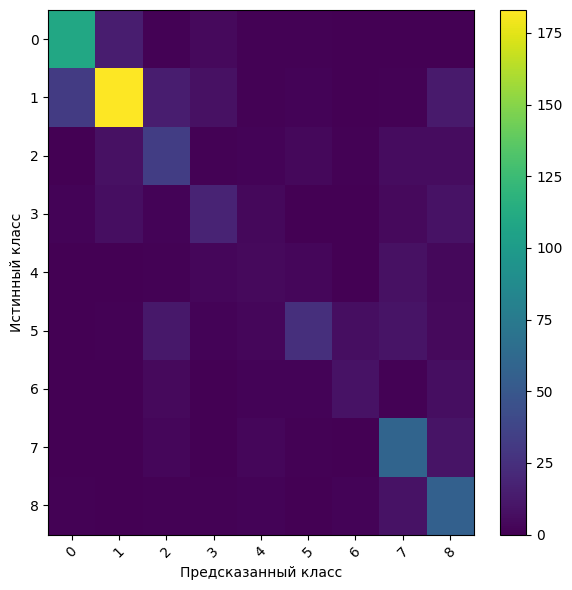

In [ ]:
conf_matrix(y_test, pred)

In [ ]:
get_metrics_per_class(y_test, pred)

,accuracy,f1_score
class,,
0,0.827068,0.791367
1,0.717647,0.780384
2,0.540984,0.492537
3,0.382979,0.423529
4,0.208333,0.212766
5,0.384615,0.485437
6,0.346154,0.400000
7,0.776316,0.674286
8,0.777778,0.615385


## XGB

In [ ]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 9,
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0)
    }

    model = XGBClassifier(**params)
    model.fit(x, y)

    y_pred = model.predict(x_val)
    return accuracy_score(y_val, y_pred)

# Запуск оптимизации
study = optuna.create_study(direction="maximize")  # Ищем max accuracy
study.optimize(objective, n_trials=50)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)

NameError: name 'optuna' is not defined

In [ ]:
xgb = XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.07078025811321921, max_depth=46, n_estimators = 1284, subsample=0.5458605221291573, colsample_bytree= 0.15268221810604315)
xgb.fit(x, y)
# Предсказания и оценка
y_pred = xgb.predict(x_test)
print("Accuracy for XGB:", accuracy_score(y_test, y_pred))
print("F1 score for XGB:",f1_score(y_test, y_pred, average='weighted'))
print("Balanced accuracy for XGB:",balanced_accuracy_score(y_test,y_pred))

Accuracy for XGB: 0.8181818181818182
F1 score for XGB: 0.8194542803411374
Balanced accuracy for XGB: 0.7899137165233105


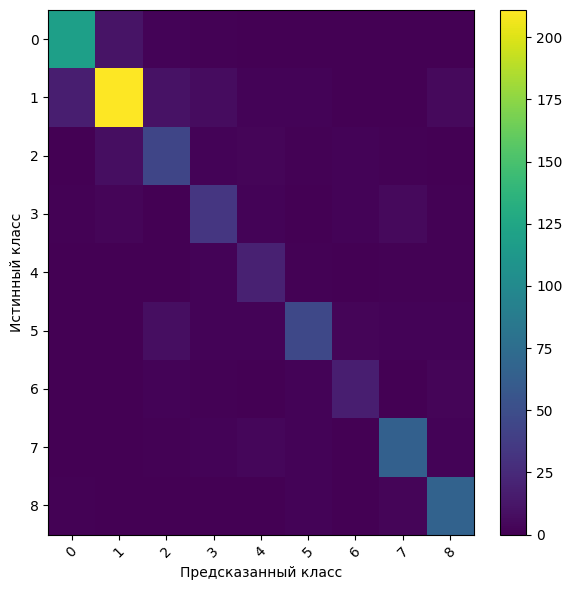

In [ ]:
conf_matrix(y_test, y_pred)

In [ ]:
get_metrics_per_class(y_test, y_pred)

,accuracy,f1_score
class,,
0,0.894737,0.875000
1,0.827451,0.864754
2,0.721311,0.687500
3,0.702128,0.680412
4,0.791667,0.678571
5,0.707692,0.760331
6,0.692308,0.705882
7,0.855263,0.849673
8,0.916667,0.868421


# GigaChat

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!pip install transformers==4.46.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.0 MB/s eta 0:00:00
Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [ ]:
model1 = AutoModel.from_pretrained('ai-sage/Giga-Embeddings-instruct', trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model1.to(device)

GigarEmbedModel(
  (latent_attention_model): LatentAttentionModel(
    (cross_attend_blocks): ModuleList(
      (0-1): 2 x PreNorm()
    )
  )
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=2)
    (layers): ModuleList(
      (0-26): 27 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (in

In [ ]:
def get_embeddings(text):
  task_name_to_instruct = {"example": "получая резюме, присвой ему метку класса от 0 до 8"}
  query_prefix = task_name_to_instruct["example"] + "\nрезюме: "
  queries = [text]
  query_embeddings = model1.encode(queries, instruction=query_prefix)
  query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
  return query_embeddings[0].cpu().numpy()

In [ ]:
x1 = np.zeros((len(X_train), 2048))

In [ ]:
y1 = np.array(y_train)

In [ ]:
for ind, sent in enumerate(tqdm(X_train)):
   x1[ind] =  get_embeddings(sent)

100%|██████████| 3024/3024 [05:44<00:00,  8.78it/s]


In [ ]:
x1_test = np.zeros((len(X_test), 2048))

In [ ]:
y1_test = np.array(y_test)

In [ ]:
for ind, sent in enumerate(tqdm(X_test)):
   x1_test[ind] =  get_embeddings(sent)

100%|██████████| 759/759 [01:21<00:00,  9.26it/s]


In [ ]:
x1_val = np.zeros((len(X_val), 2048))
y1_val = np.array(y_val)

In [ ]:
for ind, sent in enumerate(tqdm(X_val)):
   x1_val[ind] =  get_embeddings(sent)

100%|██████████| 337/337 [00:38<00:00,  8.68it/s]


In [ ]:
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(x1, y1)

LogisticRegression(max_iter=2000)

In [ ]:
pred = logistic_reg.predict(x1_test)

In [ ]:
print("Accuracy for Logistic Regression:", accuracy_score(y1_test, pred))
print("F1 score for Logistic Regression:", f1_score(y1_test, pred, average='weighted'))
print("Balanced accuracy for Logistic Regression:",balanced_accuracy_score(y1_test,pred))

Accuracy for Logistic Regression: 0.6534914361001317
F1 score for Logistic Regression: 0.652558570955313
Balanced accuracy for Logistic Regression: 0.578973436379129


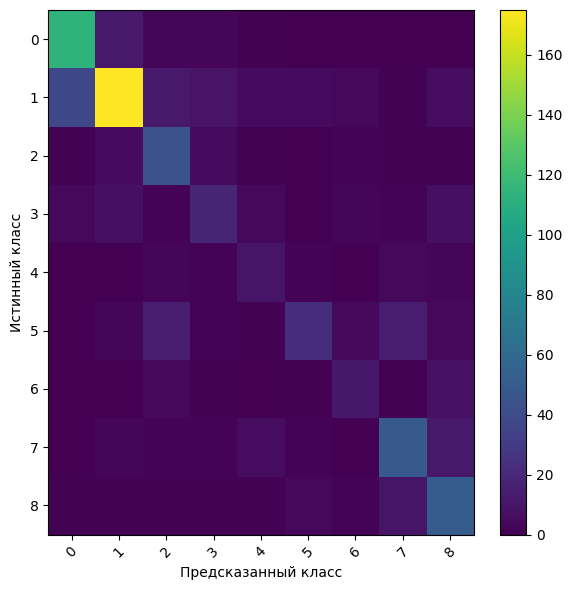

In [ ]:
conf_matrix(y_test, pred)

In [ ]:
get_metrics_per_class(y_test, pred)

,accuracy,f1_score
class,,
0,0.857143,0.783505
1,0.686275,0.759219
2,0.737705,0.608108
3,0.382979,0.400000
4,0.416667,0.377358
5,0.353846,0.450980
6,0.423077,0.423077
7,0.644737,0.624204
8,0.708333,0.621951


In [ ]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 9,
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0)
    }

    model = XGBClassifier(**params)
    model.fit(x1, y1)

    y1_pred = model.predict(x1_val)
    return accuracy_score(y1_val, y1_pred)

# Запуск оптимизации
study = optuna.create_study(direction="maximize")  # Ищем max accuracy
study.optimize(objective, n_trials=50)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)

[I 2025-03-14 13:44:57,154] A new study created in memory with name: no-name-7c03ffe0-3f22-4840-b86c-8c09625ee97b
<ipython-input-156-89775a92e603>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
[I 2025-03-14 13:51:02,805] Trial 0 finished with value: 0.8797653958944281 and parameters: {'learning_rate': 0.014418637197041095, 'max_depth': 13, 'n_estimators': 401, 'subsample': 0.7702200699105977, 'colsample_bytree': 0.4152360311921744}. Best is trial 0 with value: 0.8797653958944281.
<ipython-input-156-89775a92e603>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_logun

Лучшие параметры: {'learning_rate': 0.08416526825199985, 'max_depth': 60, 'n_estimators': 526, 'subsample': 0.5329348943634309, 'colsample_bytree': 0.92995391106007}


In [ ]:
xgb1 = XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.07078025811321921, max_depth=45, n_estimators = 700, subsample=0.5458605221291573, colsample_bytree= 0.15268221810604315)
xgb1.fit(x1, y1)
# Предсказания и оценка
y_pred2 = xgb1.predict(x1_test)
print("Accuracy for XGB:", accuracy_score(y1_test, y_pred2))
print("F1 score for XGB:",f1_score(y1_test, y_pred2, average='weighted'))
print("Balanced accuracy for XGB:",balanced_accuracy_score(y1_test,y_pred2))

Accuracy for XGB: 0.8313570487483531
F1 score for XGB: 0.832647390990648
Balanced accuracy for XGB: 0.8071414528668313


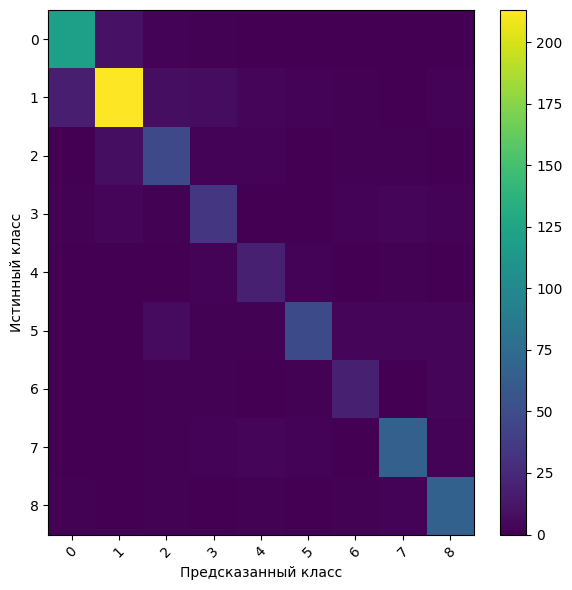

In [ ]:
conf_matrix(y_test, y_pred2)

In [ ]:
get_metrics_per_class(y_test, y_pred2)

,accuracy,f1_score
class,,
0,0.902256,0.879121
1,0.835294,0.871166
2,0.770492,0.734375
3,0.723404,0.701031
4,0.791667,0.690909
5,0.738462,0.800000
6,0.730769,0.716981
7,0.855263,0.855263
8,0.916667,0.874172
